<a href="https://colab.research.google.com/github/yiyixuxu/TimesFormer_rolled_attention/blob/main/visualizing_space_time_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# setup

install packages required for TimesFormer

install TimeSformer 

* we are using a version I forked - where I added some example data and fixed a few import issue so we can use with colab

In [7]:
%cd TimeSformer

[Errno 2] No such file or directory: 'TimeSformer'
/work/TimeSformer-rolled-attention/TimeSformer


In [8]:
# export
from pathlib import Path
from timesformer.models.vit import *
from timesformer.datasets import utils as utils
from timesformer.config.defaults import get_cfg
from einops import rearrange, repeat, reduce
import cv2
#from google.colab.patches import cv2_imshow
import torch
import torchvision.transforms as transforms
from PIL import Image
import json
import matplotlib.pyplot as plt
import numpy as np

# Utilities

In [9]:
# export
DEFAULT_MEAN = [0.45, 0.45, 0.45]
DEFAULT_STD = [0.225, 0.225, 0.225]
# convert video path to input tensor for model
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(DEFAULT_MEAN,DEFAULT_STD),
    transforms.Resize(224),
    transforms.CenterCrop(224),
])

# convert the video path to input for cv2_imshow()
transform_plot = transforms.Compose([
    lambda p: cv2.imread(str(p),cv2.IMREAD_COLOR),
    transforms.ToTensor(),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    lambda x: rearrange(x*255, 'c h w -> h w c').numpy()
])


def get_frames(path_to_video, num_frames=8):
  "return a list of paths to the frames of sampled from the video"
  path_to_frames = list(path_to_video.iterdir())
  path_to_frames.sort(key=lambda f: int(f.with_suffix('').name[-6:]))
  assert num_frames <= len(path_to_frames), "num_frames can't exceed the number of frames extracted from videos"
  if len(path_to_frames) == num_frames:
    return(path_to_frames)
  else:
    video_length = len(path_to_frames)
    seg_size = float(video_length - 1) / num_frames 
    seq = []
    for i in range(num_frames):
      start = int(np.round(seg_size * i))
      end = int(np.round(seg_size * (i + 1)))
      seq.append((start + end) // 2)
      path_to_frames_new = [path_to_frames[p] for p in seq]
    return(path_to_frames_new)

def create_video_input(path_to_video):
  "create the input tensor for TimeSformer model"
  path_to_frames = get_frames(path_to_video)
  frames = [transform(cv2.imread(str(p), cv2.IMREAD_COLOR)) for p in path_to_frames]
  frames = torch.stack(frames, dim=0)
  frames = rearrange(frames, 't c h w -> c t h w')
  frames = frames.unsqueeze(dim=0)
  return(frames)

def show_mask_on_image(img, mask):
    img = np.float32(img) / 255
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)


def create_masks(masks_in, np_imgs):
  masks = []
  for mask, img in zip(masks_in, np_imgs):
    mask= cv2.resize(mask, (img.shape[1], img.shape[0]))
    mask = show_mask_on_image(img, mask)
    masks.append(mask)
  return(masks)

In [10]:
# export
def combine_divided_attention(attn_t, attn_s):
  ## time attention
    # average time attention weights across heads
  attn_t = attn_t.mean(dim = 1)
    # add cls_token to attn_t as an identity matrix since it only attends to itself 
  I = torch.eye(attn_t.size(-1)).unsqueeze(0)
  attn_t = torch.cat([I,attn_t], 0)
    # adding identity matrix to account for skipped connection 
  attn_t = attn_t +  torch.eye(attn_t.size(-1))[None,...]
    # renormalize
  attn_t = attn_t / attn_t.sum(-1)[...,None]

  ## space attention
   # average across heads
  attn_s = attn_s.mean(dim = 1)
   # adding residual and renormalize 
  attn_s = attn_s +  torch.eye(attn_s.size(-1))[None,...]
  attn_s = attn_s / attn_s.sum(-1)[...,None]
  
  ## combine the space and time attention
  attn_ts = einsum('tpk, ktq -> ptkq', attn_s, attn_t)
  
  ## average the cls_token attention across the frames
   # splice out the attention for cls_token
  attn_cls = attn_ts[0,:,:,:]
   # average the cls_token attention and repeat across the frames
  attn_cls_a = attn_cls.mean(dim=0)
  attn_cls_a = repeat(attn_cls_a, 'p t -> j p t', j = 8)
   # add it back
  attn_ts = torch.cat([attn_cls_a.unsqueeze(0),attn_ts[1:,:,:,:]],0)
  return(attn_ts)

class DividedAttentionRollout():
  def __init__(self, model, **kwargs):
    self.model = model
    self.hooks = []

  def get_attn_t(self, module, input, output):
    self.time_attentions.append(output.detach().cpu())
  def get_attn_s(self, module, input, output):
    self.space_attentions.append(output.detach().cpu())

  def remove_hooks(self): 
    for h in self.hooks: h.remove()
    
  def __call__(self, path_to_video):
    input_tensor = create_video_input(path_to_video)
    self.model.zero_grad()
    self.time_attentions = []
    self.space_attentions = []
    self.attentions = []
    for name, m in model.named_modules():
      if 'temporal_attn.attn_drop' in name:
        self.hooks.append(m.register_forward_hook(self.get_attn_t))
      elif 'attn.attn_drop' in name:
        self.hooks.append(m.register_forward_hook(self.get_attn_s))
    preds = self.model(input_tensor)
    for h in self.hooks: h.remove()
    for attn_t,attn_s in zip(self.time_attentions, self.space_attentions):
      self.attentions.append(combine_divided_attention(attn_t,attn_s))
    p,t = self.attentions[0].shape[0], self.attentions[0].shape[1]
    result = torch.eye(p*t)
    for attention in self.attentions:
      attention = rearrange(attention, 'p1 t1 p2 t2 -> (p1 t1) (p2 t2)')
      result = torch.matmul(attention, result)
    mask = rearrange(result, '(p1 t1) (p2 t2) -> p1 t1 p2 t2', p1 = p, p2=p)
    mask = mask.mean(dim=1)
    mask = mask[0,1:,:]
    width = int(mask.size(0)**0.5)
    mask = rearrange(mask, '(h w) t -> h w t', w = width).numpy()
    mask = mask / np.max(mask)
    return(mask)



# load the pretrained model

download the pre-trainde model

load the model

In [11]:
model_file = 'TimeSformer_divST_8_224_SSv2.pyth'
Path(model_file).exists()

True

In [12]:
cfg = get_cfg()
cfg.merge_from_file('configs/SSv2/TimeSformer_divST_8_224.yaml')
cfg.TRAIN.ENABLE = False
cfg.TIMESFORMER.PRETRAINED_MODEL = model_file
model = MODEL_REGISTRY.get('vit_base_patch16_224')(cfg)

read the labels

In [13]:
with open('example_data/labels.json') as f:
  ssv2_labels = json.load(f)
ssv2_labels = list(ssv2_labels.keys())

inference

In [14]:
path_to_video = Path('example_data/74225/')
path_to_video.exists()

True

In [15]:
with torch.set_grad_enabled(False):
  np.random.seed(cfg.RNG_SEED)
  torch.manual_seed(cfg.RNG_SEED)
  model.eval();
  pred = model(create_video_input(path_to_video)).cpu().detach()

In [16]:
topk_scores, topk_label = torch.topk(pred, k=5, dim=-1)
for i in range(5):
  pred_name = ssv2_labels[topk_label.squeeze()[i].item()]
  print(f"Prediction index {i}: {pred_name:<25}, score: {topk_scores.squeeze()[i].item():.3f}")

Prediction index 0: Spinning something that quickly stops spinning, score: 10.784
Prediction index 1: Pushing something so it spins, score: 6.702
Prediction index 2: Moving something and something away from each other, score: 6.362
Prediction index 3: Tipping something over   , score: 5.734
Prediction index 4: Spinning something so it continues spinning, score: 5.604


# visualizing the learned space-time attention

Create a `DividedAttentionRollout` object (`att_roll`) and call it to get a mask for a given video

In [22]:
att_roll = DividedAttentionRollout(model)
masks = att_roll(path_to_video)

plot

In [23]:
np_imgs = [transform_plot(p) for p in get_frames(path_to_video)]
masks = create_masks(list(rearrange(masks, 'h w t -> t h w')),np_imgs)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


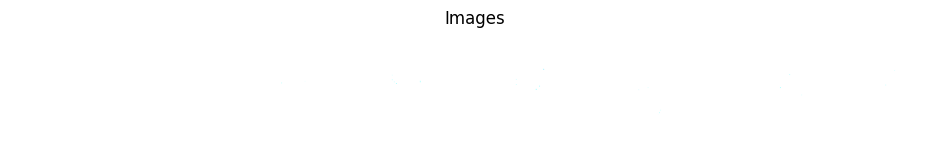

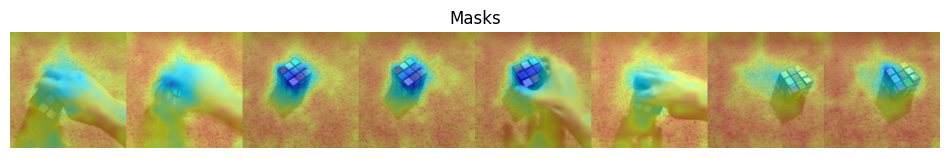

In [24]:
def display_images(images, title=''):
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    ax.imshow(np.hstack(images))
    ax.axis('off')
    ax.set_title(title)
    plt.show()

# Display images and masks using Matplotlib
display_images(np_imgs, title='Images')
display_images(masks, title='Masks')